## Assignment for Machine Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### Data exploration

In [3]:
train_path = './train-3.csv'
test_path = './test-4.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
print('train_data shape: ', train_data.shape)

train_data shape:  (40007, 21)


In [5]:
print('test_data shape: ', test_data.shape)

test_data shape:  (4446, 21)


In [6]:
print("\nClass Distribution:")
class_dist = train_data['TYPE'].value_counts()
print(class_dist)


Class Distribution:
TYPE
FLU        22499
ALLERGY    14729
COVID       1849
COLD         930
Name: count, dtype: int64


In [7]:
print('Data info: ')
train_data.info()

Data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40007 entries, 0 to 40006
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 40007 non-null  int64 
 1   MUSCLE_ACHES          40007 non-null  int64 
 2   TIREDNESS             40007 non-null  int64 
 3   SORE_THROAT           40007 non-null  int64 
 4   RUNNY_NOSE            40007 non-null  int64 
 5   STUFFY_NOSE           40007 non-null  int64 
 6   FEVER                 40007 non-null  int64 
 7   NAUSEA                40007 non-null  int64 
 8   VOMITING              40007 non-null  int64 
 9   DIARRHEA              40007 non-null  int64 
 10  SHORTNESS_OF_BREATH   40007 non-null  int64 
 11  DIFFICULTY_BREATHING  40007 non-null  int64 
 12  LOSS_OF_TASTE         40007 non-null  int64 
 13  LOSS_OF_SMELL         40007 non-null  int64 
 14  ITCHY_NOSE            40007 non-null  int64 
 15  ITCHY_EYES            40

In [8]:
# Get all columns except 'TYPE'
feature_columns = train_data.columns[train_data.columns != 'TYPE']

# Create lists to store the counts
features = []
counts_0 = []
counts_1 = []
percentages = []

# Calculate counts for each feature
for feature in feature_columns:
    counts = train_data[feature].value_counts().sort_index()
    percentage_1 = (counts[1] / len(train_data)) * 100
    
    features.append(feature)
    counts_0.append(counts[0])
    counts_1.append(counts[1])
    percentages.append(f"{percentage_1:.2f}%")

# Create DataFrame from lists
value_counts = pd.DataFrame({
    'Feature': features,
    'Count_0': counts_0,
    'Count_1': counts_1,
    'Percentage_1': percentages
})

# Sort by Count_1 in descending order
value_counts = value_counts.sort_values('Count_1', ascending=False)

# Display the results with clean formatting
print("\nFeature Distribution Analysis:")
print("-" * 80)
print(f"{'Feature':<25} {'Count_0':>10} {'Count_1':>10} {'Percentage_1':>12}")
print("-" * 80)
for _, row in value_counts.iterrows():
    print(f"{row['Feature']:<25} {row['Count_0']:>10} {row['Count_1']:>10} {row['Percentage_1']:>12}")
print("-" * 80)


Feature Distribution Analysis:
--------------------------------------------------------------------------------
Feature                      Count_0    Count_1 Percentage_1
--------------------------------------------------------------------------------
COUGH                          19135      20872       52.17%
SNEEZING                       19180      20827       52.06%
MUSCLE_ACHES                   19181      20826       52.06%
SORE_THROAT                    19242      20765       51.90%
TIREDNESS                      19263      20744       51.85%
RUNNY_NOSE                     20159      19848       49.61%
STUFFY_NOSE                    20184      19823       49.55%
LOSS_OF_SMELL                  23069      16938       42.34%
LOSS_OF_TASTE                  23143      16864       42.15%
NAUSEA                         27024      12983       32.45%
SHORTNESS_OF_BREATH            27027      12980       32.44%
DIFFICULTY_BREATHING           27038      12969       32.42%
VOMITING     

The training dataset consists of 40,007 records with 21 features, including 20 binary symptom indicators (encoded as integers) and one target variable 'TYPE' (as object type). Each row represents a patient case, where symptoms are marked as present (1) or absent (0). The dataset is complete with no missing values across all columns, making it clean and ready for analysis. The symptoms cover a wide range of indicators from respiratory issues (like cough and breathing difficulties) to allergic reactions (such as itchy nose and eyes), which will be used to classify four different health conditions.

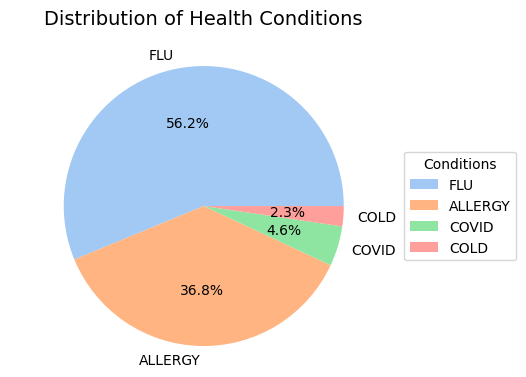

In [9]:
# Create pie chart
plt.figure(figsize=(5, 4))
plt.pie(class_dist.values, 
        labels=class_dist.index,
        autopct='%1.1f%%',  # Show percentage with 1 decimal place
        colors=sns.color_palette('pastel'))  # Use pastel color palette

plt.title('Distribution of Health Conditions', pad=20, size=14)
plt.legend(title="Conditions", 
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

The pie chart demonstrates the distribution of health conditions in our dataset, showing a notable imbalance among different classes. Flu represents the dominant class with 22,499 cases (56.2% of the dataset), followed by Allergy with 14,729 cases (36.8%). The remaining cases are distributed between COVID with 1,849 instances (4.6%) and Cold with 930 cases (2.3%), which form the minority classes. This significant class imbalance will need to be addressed in our classification approach to ensure balanced model performance across all health conditions.

### Data preprocess

In [10]:
# Separate features and target
X_train = train_data.drop('TYPE', axis=1)
y_train_ori = train_data['TYPE']

# get x_test and y_test from test_data 
X_test = test_data.drop('TYPE', axis=1)
y_test_ori = test_data['TYPE']

##### Apply standardization to scale features

In [30]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [31]:
# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_ori)
y_test = le.fit_transform(y_test_ori)

In [32]:
print(list(y_train_ori[:20]))
print(y_train[:20])

print(list(y_test_ori[:20]))
print(y_test[:20])

['ALLERGY', 'FLU', 'ALLERGY', 'FLU', 'FLU', 'FLU', 'ALLERGY', 'FLU', 'FLU', 'FLU', 'FLU', 'FLU', 'FLU', 'FLU', 'FLU', 'ALLERGY', 'ALLERGY', 'ALLERGY', 'ALLERGY', 'COVID']
[0 3 0 3 3 3 0 3 3 3 3 3 3 3 3 0 0 0 0 2]
['FLU', 'FLU', 'FLU', 'FLU', 'FLU', 'ALLERGY', 'ALLERGY', 'FLU', 'FLU', 'ALLERGY', 'FLU', 'FLU', 'FLU', 'FLU', 'FLU', 'ALLERGY', 'FLU', 'FLU', 'ALLERGY', 'FLU']
[3 3 3 3 3 0 0 3 3 0 3 3 3 3 3 0 3 3 0 3]


Since no validation set was provided, we randomly split the original training set into training and validation sets at a ratio of 4:1 (80% for training and 20% for validation), using stratified sampling to ensure that the proportion of samples for each class remains the same as in the original training set.

In [14]:
# Split data
# X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
#     X_train_scaled, y_train, 
#     test_size=0.2,
#     random_state=42,
#     stratify=y_train
# )

In [33]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((40007, 20), (40007,), (4446, 20), (4446,))

undersampling for FLU and ALLERGY type

In [16]:
y_train[:30]

array([0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 1, 3, 2, 0, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 0, 0, 3, 3])

In our dataset, there is a significant class imbalance issue. Specifically, the Cold and COVID categories account for only 2.3% and 4.6% of the data, respectively, while the other two categories (FLU and ALLERGY) make up 56.2% and 36.8%. This imbalance can lead to a model that is biased towards predicting the majority classes, potentially neglecting the minority classes.  
To address this issue, we can employ sampling techniques such as oversampling and undersampling. Oversampling increases the number of samples in the minority classes to balance the dataset, while undersampling reduces the number of samples in the majority classes. In our experiment, we used undersampling to decrease the number of majority class samples, allowing the model to better learn the features of the minority classes.  
This approach helps improve the model's ability to recognize minority classes, although it may result in the loss of information from the majority classes. Therefore, it is crucial to carefully balance data equality and information retention when applying these techniques. By doing so, we aim to enhance the model's overall performance across all categories, particularly in predicting the minority classes, Cold and COVID.  

In [34]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy={3: 7000,
                                                             0: 7000})
X_train_underSample, y_train_underSample = rus.fit_resample(X_train_scaled, y_train)

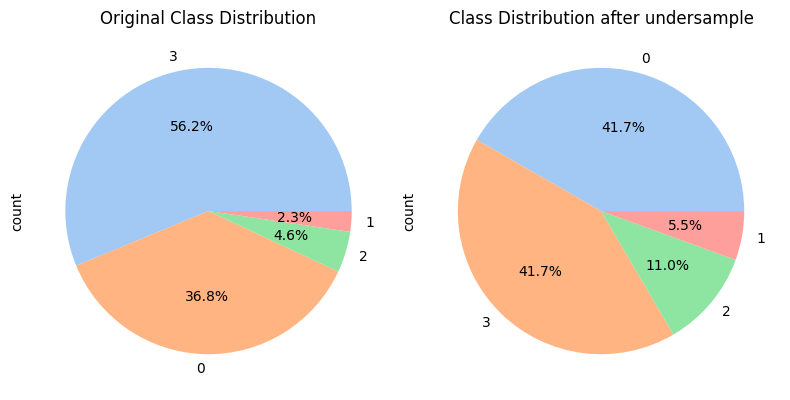

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
# Original distribution pie chart
pd.Series(y_train).value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=ax1,
    colors=sns.color_palette('pastel')
)
ax1.set_title('Original Class Distribution')

# Resampled distribution pie chart
pd.Series(y_train_underSample).value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=ax2,
    colors=sns.color_palette('pastel')
)
ax2.set_title('Class Distribution after undersample')

plt.tight_layout()
plt.show()

In [35]:
X_train_underSample.shape, y_train_underSample.shape

((16779, 20), (16779,))

### Classification Task

#### Classifier1: random forest

In [38]:
# Initialize Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=9,          # Optimized: reduced from 100 to 9
    max_depth=11,           # Optimized: changed from 10 to 11
    criterion='gini',       # Explicitly specify Gini impurity
    random_state=42,        # For reproducibility
    class_weight='balanced' # Handle class imbalance
)

# Train model
rf_model.fit(X_train_underSample, y_train_underSample)

# Predictions
y_pred_test_rf = rf_model.predict(X_test_scaled)
score_test = rf_model.score(X_test_scaled, y_test)
# Print results
print("\nRandom Forest Classification Report on test-set:")
print("\nAverage Accuracy: ", score_test)
print(classification_report(y_test, y_pred_test_rf, 
                            target_names=le.classes_,))


Random Forest Classification Report on test-set:

Average Accuracy:  0.9251012145748988
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      1652
        COLD       0.45      1.00      0.62        94
       COVID       0.47      0.97      0.63       199
         FLU       1.00      0.89      0.94      2501

    accuracy                           0.93      4446
   macro avg       0.73      0.96      0.79      4446
weighted avg       0.96      0.93      0.94      4446



Parameters selection

In [39]:
# parameters
param_grid = {
    'max_depth': np.arange(1,20),
    'n_estimators': np.arange(1,10),
    'criterion' : ["gini", "entropy", "log_loss"]
    # 'max_leaf_nodes': np.arange(1,51,5),
}
rf = RandomForestClassifier(random_state=42)

# fitting
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, verbose=3, return_train_score=True)
grid_search_rf.fit(X_train_underSample, y_train_underSample)

Fitting 5 folds for each of 513 candidates, totalling 2565 fits
[CV 1/5] END criterion=gini, max_depth=1, n_estimators=1;, score=(train=0.626, test=0.628) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, n_estimators=1;, score=(train=0.627, test=0.623) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, n_estimators=1;, score=(train=0.625, test=0.631) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, n_estimators=1;, score=(train=0.627, test=0.625) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, n_estimators=1;, score=(train=0.627, test=0.625) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, n_estimators=2;, score=(train=0.626, test=0.628) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, n_estimators=2;, score=(train=0.627, test=0.623) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, n_estimators=2;, score=(train=0.625, test=0.631) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, n_estimators=2

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             return_train_score=True, verbose=3)

In [49]:
# Initialize Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=9,          # Optimized: reduced from 100 to 9
    max_depth=12,           # Optimized: changed from 10 to 11
    criterion='gini',       # Explicitly specify Gini impurity
    random_state=42,        # For reproducibility
    class_weight='balanced' # Handle class imbalance
)

# Train model
rf_model.fit(X_train_underSample, y_train_underSample)

# Predictions
y_pred_test_rf = rf_model.predict(X_test_scaled)
score_test = rf_model.score(X_test_scaled, y_test)

# Print results
print("\nRandom Forest Classification Report on test-set:")
print("\nAverage Accuracy: ", score_test)
print(classification_report(y_test, y_pred_test_rf, 
                            target_names=le.classes_,))


Random Forest Classification Report on test-set:

Average Accuracy:  0.9257759784075573
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      1652
        COLD       0.45      1.00      0.62        94
       COVID       0.47      0.97      0.64       199
         FLU       1.00      0.89      0.94      2501

    accuracy                           0.93      4446
   macro avg       0.73      0.96      0.80      4446
weighted avg       0.96      0.93      0.94      4446



#### Experiment Summary
In this experiment, we optimized the parameters of a Random Forest classifier using grid search. The parameter grid included variations in max_depth, n_estimators, and criterion. The grid search was conducted with 5-fold cross-validation on the undersampled training data.  
*Results*:
*Validation Set*: The cross-validation accuracy reached 0.951, indicating a strong model performance during training.
*Test Set*: The average precision across classes was 0.9258, demonstrating the model's ability to generalize well to unseen data.
*Detailed Test Set Performance*:  
ALLERGY: Precision of 1.00, recall of 0.97, and F1-score of 0.98.  
COLD: Precision of 0.45, recall of 1.00, and F1-score of 0.62.  
COVID: Precision of 0.47, recall of 0.97, and F1-score of 0.64.  
FLU: Precision of 1.00, recall of 0.89, and F1-score of 0.94.  
Overall, the model achieved an accuracy of 0.9258 on the test set, with a macro average F1-score of 0.80 and a weighted average F1-score of 0.94. The results indicate excellent performance for majority classes but highlight the need for improved precision in minority classes.

#### Classifier4: LR

Parameters selection

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Define parameter grid
param_grid = {
    'estimator__C': [0.1, 0.5, 1, 5, 10],  # Regularization strength
    'estimator__penalty': ['l1', 'l2'],    # Type of regularization
    'estimator__solver': ['liblinear', 'saga']  # Solver
}

# Initialize Logistic Regression model
lr = LogisticRegression(
    max_iter=1000,         # Maximum iterations for convergence
    random_state=42,       # For reproducibility
    class_weight='balanced' # Handle class imbalance
)

# Wrap Logistic Regression with OneVsRestClassifier
ovr = OneVsRestClassifier(lr)

# Perform grid search
grid_search_lr = GridSearchCV(ovr, param_grid, cv=5, verbose=3, return_train_score=True)
grid_search_lr.fit(X_train_underSample, y_train_underSample)

# Output best parameters
print("Best parameters found: ", grid_search_lr.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.946, test=0.948) total time=   0.4s
[CV 2/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.945, test=0.951) total time=   0.4s
[CV 3/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.947, test=0.942) total time=   0.4s
[CV 4/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.947, test=0.942) total time=   0.4s
[CV 5/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.946, test=0.948) total time=   0.4s
[CV 1/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga;, score=(train=0.946, test=0.948) total time=   0.2s
[CV 2/5] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga;, score=(train=0.945, test=0.951) total time=   0.2s
[CV

In [68]:
# Initialize Logistic Regression classifier with optimized parameters
lr_model = LogisticRegression(
    C=0.1,                 # Optimized regularization strength (from grid search)
    max_iter=1000,         # Maximum iterations for convergence
    random_state=42,       # For reproducibility
    class_weight='balanced', # Handle class imbalance
    penalty='l1',           # L2 regularization (Ridge)
    solver='liblinear',
)

# Train the Logistic Regression model
print("Training Logistic Regression model...")
lr_model.fit(X_train_underSample, y_train_underSample)

# Make predictions on test set
y_pred_test_lr = lr_model.predict(X_test_scaled)
score_test = lr_model.score(X_test_scaled, y_test)

# Print test set results
print("\nLogistic Regression Classification Report on test-set:")
print("\nAverage Accuracy: ", score_test)
print(classification_report(y_test, y_pred_test_lr, 
                          target_names=le.classes_,
                          zero_division=1))

Training Logistic Regression model...

Logistic Regression Classification Report on test-set:

Average Accuracy:  0.926225820962663
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      1652
        COLD       0.46      1.00      0.63        94
       COVID       0.47      0.97      0.64       199
         FLU       1.00      0.89      0.94      2501

    accuracy                           0.93      4446
   macro avg       0.73      0.96      0.80      4446
weighted avg       0.96      0.93      0.94      4446



#### Experiment Summary
In this experiment, we performed a grid search with cross-validation to optimize the parameters of a Logistic Regression model wrapped in a OneVsRestClassifier. The parameter grid included variations in regularization strength (C), type of regularization (penalty), and solver.

Grid Search Results:  
Best Parameters Found:  
estimator__C: 0.1  
estimator__penalty: 'l1'  
estimator__solver: 'liblinear'  

Test Set Performance:
Average Accuracy: 0.9262

Detailed Classification Report:  
ALLERGY: Precision of 1.00, recall of 0.97, and F1-score of 0.98.  
COLD: Precision of 0.46, recall of 1.00, and F1-score of 0.63.  
COVID: Precision of 0.47, recall of 0.97, and F1-score of 0.64.  
FLU: Precision of 1.00, recall of 0.89, and F1-score of 0.94.  

Overall Metrics:
Accuracy: 0.93
Macro Average: Precision of 0.73, recall of 0.96, and F1-score of 0.80.
Weighted Average: Precision of 0.96, recall of 0.93, and F1-score of 0.94.
The results indicate strong performance for majority classes, with room for improvement in precision for minority classes.

### Clustering Task

#### Cluster1: K-Means

In [72]:
train_data.shape

(40007, 21)

In [75]:
train_data

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,...,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,1,0,1,1,0,1,0,0,0,0,...,0,1,1,1,1,1,0,1,1,ALLERGY
1,1,1,0,0,1,0,0,0,1,1,...,1,1,1,0,0,0,0,1,0,FLU
2,1,1,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,1,0,1,ALLERGY
3,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,FLU
4,1,0,1,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,1,0,FLU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40002,0,0,1,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,ALLERGY
40003,1,0,0,1,1,1,0,0,0,0,...,0,1,0,1,1,0,1,0,0,ALLERGY
40004,1,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,FLU
40005,0,0,1,0,1,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,ALLERGY


In [76]:
X_train.shape

(40007, 20)

In [83]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Prepare data for clustering (excluding the target variable)
X_train = train_data.drop(columns=['TYPE'])

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train)

# Evaluate K-Means
kmeans_silhouette = silhouette_score(X_train, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Compare with true labels
true_labels = train_data['TYPE'].factorize()[0]
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
print(f"K-Means Adjusted Rand Index: {kmeans_ari}")

K-Means Silhouette Score: 0.05308705947456767
K-Means Adjusted Rand Index: 0.40885705299760833


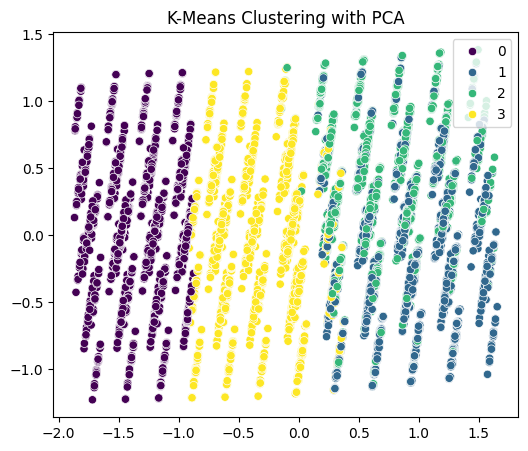

In [82]:
# Visualize K-Means Clustering Results
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Visualize K-Means Clustering Results with PCA
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('K-Means Clustering with PCA')
plt.show()

#### Experiment Summary
In this experiment, we applied K-Means clustering to explore patterns in the dataset and evaluated the clustering performance using silhouette score and adjusted Rand index.

We used K-Means with 4 clusters, as specified by the number of known classes.

Dimensionality Reduction: PCA was applied to reduce the data to two dimensions for visualization purposes.  
*Silhouette Score*: 0.0531  
This low score indicates that the clusters are not well-separated, suggesting overlap between clusters.  
*Adjusted Rand Index (ARI)*: 0.4089  
This moderate score suggests some alignment between the clustering results and the true labels, but there is room for improvement.

#### Cluster2: Agglomerative Cluster

In [84]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_train)

# Evaluate Agglomerative Clustering
agglo_silhouette = silhouette_score(X_train, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette}")

# Compare with true labels
agglo_ari = adjusted_rand_score(true_labels, agglo_labels)
print(f"Agglomerative Clustering Adjusted Rand Index: {agglo_ari}")

Agglomerative Clustering Silhouette Score: 0.035196482859104365
Agglomerative Clustering Adjusted Rand Index: 0.5758235957560945


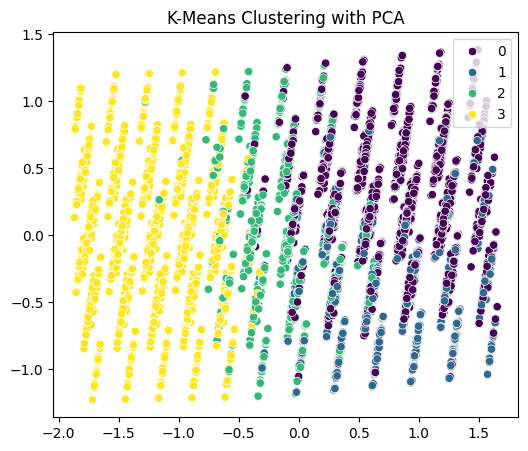

In [85]:
# Visualize Agglomerative Clustering Results
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Visualize K-Means Clustering Results with PCA
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette='viridis')
plt.title('K-Means Clustering with PCA')
plt.show()

#### Experiment Summary
In this experiment, we applied Agglomerative Clustering to the dataset and evaluated its performance using silhouette score and adjusted Rand index.

Results:  
*Silhouette Score*: 0.0352  
Indicates poor cluster separation, with significant overlap between clusters.  
*Adjusted Rand Index (ARI)*: 0.5758  
Shows moderate alignment with true labels, better than K-Means, suggesting some structure is captured.

#### Alignment Discussion:

Agglomerative Clustering:  
Adjusted Rand Index (ARI): 0.5758  
This score indicates a moderate alignment with the true labels, suggesting that the clustering captures some of the underlying structure in the data better than K-Means.  

K-Means Clustering:  
Adjusted Rand Index (ARI): 0.4089  
This score is lower than that of Agglomerative Clustering, indicating less alignment with the true labels.

#### Comparative Analysis and Reporting
In this analysis, we compared classification and clustering approaches. Classification, a supervised learning method, uses known labels to evaluate performance through metrics like accuracy, precision, recall, and F1-score. It provides clear and interpretable results, making it effective when labeled data is available. However, it requires labeled data, which may not always be accessible.  
Clustering, on the other hand, is an unsupervised learning approach that groups similar data points without prior labels. It is evaluated using metrics such as silhouette score and Adjusted Rand Index (ARI). Clustering is valuable for uncovering hidden patterns in data but can be less interpretable and heavily dependent on the choice of algorithm and parameters.  
In our findings, K-Means Clustering achieved a silhouette score of 0.0531, indicating poor separation, and an ARI of 0.4089, showing moderate alignment with true labels. Agglomerative Clustering performed slightly better, with a silhouette score of 0.0352 and an ARI of 0.5758, indicating better alignment than K-Means. Both clustering methods struggled with clear separation, as reflected in the low silhouette scores. Overall, classification offers more reliable results when labels are available, while clustering serves as a useful tool for exploratory data analysis.